In [17]:
import os
from importlib import reload

import torch
import numpy as np
import sciplots as plots
from sklearn.decomposition import PCA

from src import main
from src.utils import data
from src.utils.utils import open_config
from src.utils.clustering import CompactClusterEncoder

torch.serialization.add_safe_globals([CompactClusterEncoder])
reload(data)
reload(main)
from src.main import init

In [18]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']

bahamas_colours = ['#0049E0', '#0090E0', '#00D7E0', '#2CDEE6', '#00E09E', '#00E051'][:-2]
bahamas_agn_colours = ['#F54EDF', '#5D4EF5']
bahamas_dmo = ['#00FA8F', '#01FB3D', '#89FA00']
flamingo_colours = ['#FABD00', '#FA2100', '#FA7700']
flamingo_test = ['#FA07A0']

In [19]:
known = [
    'flamingo',
    # 'flamingo_low',
    # 'flamingo_hi',
    'bahamas_cdm',
    'bahamas_cdm_low',
    'bahamas_cdm_hi',
    'bahamas_0.1',
    'bahamas_0.3',
    'bahamas_1',
]
# unknown = ['bahamas_dmo_cdm', 'bahamas_dmo_0.1', 'bahamas_dmo_1', 'flamingo_low_test', 'noise']
unknown = ['flamingo_low_test']

loaders, net, dataset = init(known, config, unknown=unknown)

data = net.predict(loaders[1])
# data['targets'] = dataset.correct_unknowns(data['targets'].squeeze())
data['targets'] = data['targets'].squeeze()
labels = dataset.names[data['ids'][np.unique(
    data['targets'],
    return_index=True,
)[1]].astype(int)]


Training data size: 25280	Validation data size: 6320
Prediction time: 1.755e+00 s


In [10]:
transform = (np.mean(data['latent'], axis=0), np.std(data['latent'], axis=0))
norm_data = (data['latent'] - transform[0]) / transform[1]

In [26]:
data['latent'][:, 0] *= 1e6
pca = PCA(n_components=4).fit(data['latent'][np.isin(data['targets'], np.unique(data['targets'])[net._unknown:])])
# pca = PCA(n_components=4).fit(data['latent'])
pca_transform = pca.transform(data['latent'])
pca_transform[:, 0] /= 1e6
data['latent'][:, 0] /= 1e6
pca_transform.shape

(6320, 4)

In [38]:
pca = PCA(n_components=4).fit(data['latent'])
pca_transform = pca.transform(data['latent'])

In [50]:
pca = PCA(n_components=4).fit(norm_data)
pca_transform = pca.transform(norm_data)

In [45]:
variance = pca.explained_variance_.copy()
# variance[0] /= 1e6 ** 2
pca.components_
variance / np.sum(variance)

array([0.5632    , 0.21974672, 0.13043901, 0.08661421], dtype=float32)

In [9]:
transform = (np.mean(data['latent'], axis=0), np.std(data['latent'], axis=0))
norm_data = (data['latent'] - transform[0]) / transform[1]
norm_data[:, 0] *= 1e6
pca = PCA(n_components=4).fit(norm_data[np.isin(data['targets'], np.unique(data['targets'])[net._unknown:])])
pca_transform = pca.transform(norm_data)
pca_transform[:, 0] /= 1e6
norm_data[:, 0] /= 1e6

In [16]:
variance = pca.explained_variance_.copy()
variance[0] /= 1e6 ** 2
variance / np.sum(variance)
pca.explained_variance_

(2134, 7)

In [68]:
a = data['latent'].copy()
a[:, 0] *= 1e10
a[:, 1] *= 1e8
a[:, 2] *= 1e6
a[:, 3] *= 1e4
a[:, 4] *= 1e2
pca = PCA(n_components=4).fit(a)
pca_transform = pca.transform(a)
pca_transform[:, 0] /= 1e10
pca_transform[:, 1] /= 1e8
pca_transform[:, 2] /= 1e6
pca_transform[:, 3] /= 1e4
np.round(pca.components_, 3)

array([[ 1.   ,  0.02 , -0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       [-0.02 ,  1.   ,  0.006,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.006,  1.   , -0.   , -0.   ,  0.   , -0.   ],
       [ 0.   , -0.   ,  0.   ,  1.   ,  0.   , -0.   ,  0.   ]],
      dtype=float32)

In [75]:
def custom_pca(data, num):
    data -= data.mean(axis=0)
    cov = np.cov(data, rowvar=False)
    values, vectors = np.linalg.eigh(cov)
    idxs = np.argsort(values)[::-1]
    values = values[idxs]
    vectors = vectors[:, idxs][:, :num]
    return np.dot(vectors.T, data.T).T


In [96]:
a = data['latent'].copy()
a[:, 0] *= 1e6
pca_transform = custom_pca(a, 4)
pca_transform[:, 0] /= 1e6
values, vectors = np.linalg.eigh(np.cov(a - np.mean(a, axis=0), rowvar=False))
idxs = np.argsort(values)[::-1]
values = values[idxs]
vectors = vectors[:, idxs]
values[0] /= 1e12
print(np.round(values / np.sum(values), 3))
np.round(vectors, 3)

[0.221 0.542 0.136 0.06  0.032 0.006 0.003]


array([[ 1.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.787, -0.122,  0.321, -0.498,  0.089, -0.083],
       [-0.   ,  0.583,  0.159, -0.446,  0.623,  0.212,  0.053],
       [ 0.   ,  0.168, -0.159,  0.435,  0.446, -0.746,  0.029],
       [ 0.   ,  0.025, -0.765, -0.532, -0.112, -0.219, -0.265],
       [ 0.   ,  0.111,  0.478, -0.475, -0.389, -0.577,  0.224],
       [-0.   ,  0.012, -0.347,  0.003, -0.032,  0.095,  0.932]])

(-2.653313636779785, 2.9317710399627686)

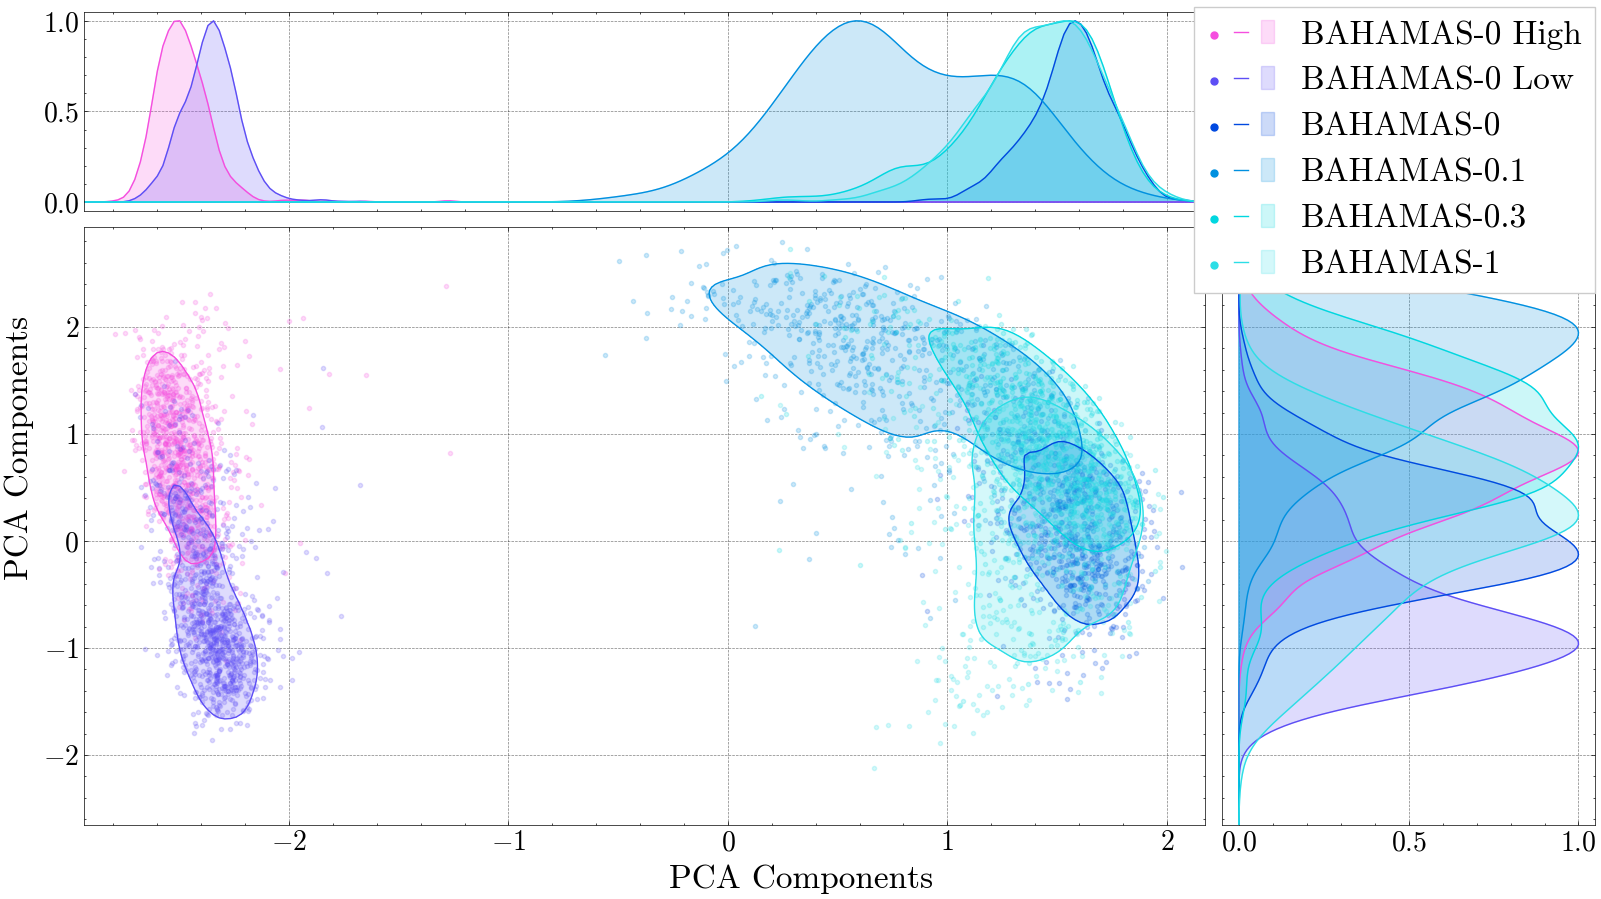

In [21]:
idxs = np.isin(data['targets'].flatten(), np.unique(data['targets'])[0:])
plot = plots.PlotClusters(
    pca_transform[idxs, :2],
    data['targets'][idxs],
    norm=True,
    density=True,
    labels=labels[2:],
    alpha=0.2,
    alpha_2d=0.2,
    # colours=['k'] + flamingo_test + bahamas_dmo + flamingo_colours[1:2] + bahamas_colours,
    colours=bahamas_agn_colours + bahamas_colours,
    x_label='PCA Components',
    y_label='PCA Components',
    rows=len(labels),
    loc='upper right',
)
plot.axes[1, 0].set_xlim((np.min(pca_transform[:, 0] - np.abs(pca_transform[:, 0] * 0.05)), np.max(pca_transform[:, 0] + np.abs(pca_transform[:, 0] * 0.05))))
plot.axes[1, 0].set_ylim((np.min(pca_transform[:, 1] - np.abs(pca_transform[:, 1] * 0.05)), np.max(pca_transform[:, 1] + np.abs(pca_transform[:, 1] * 0.05))))

In [15]:
plot.savefig('../plots/', name='test')

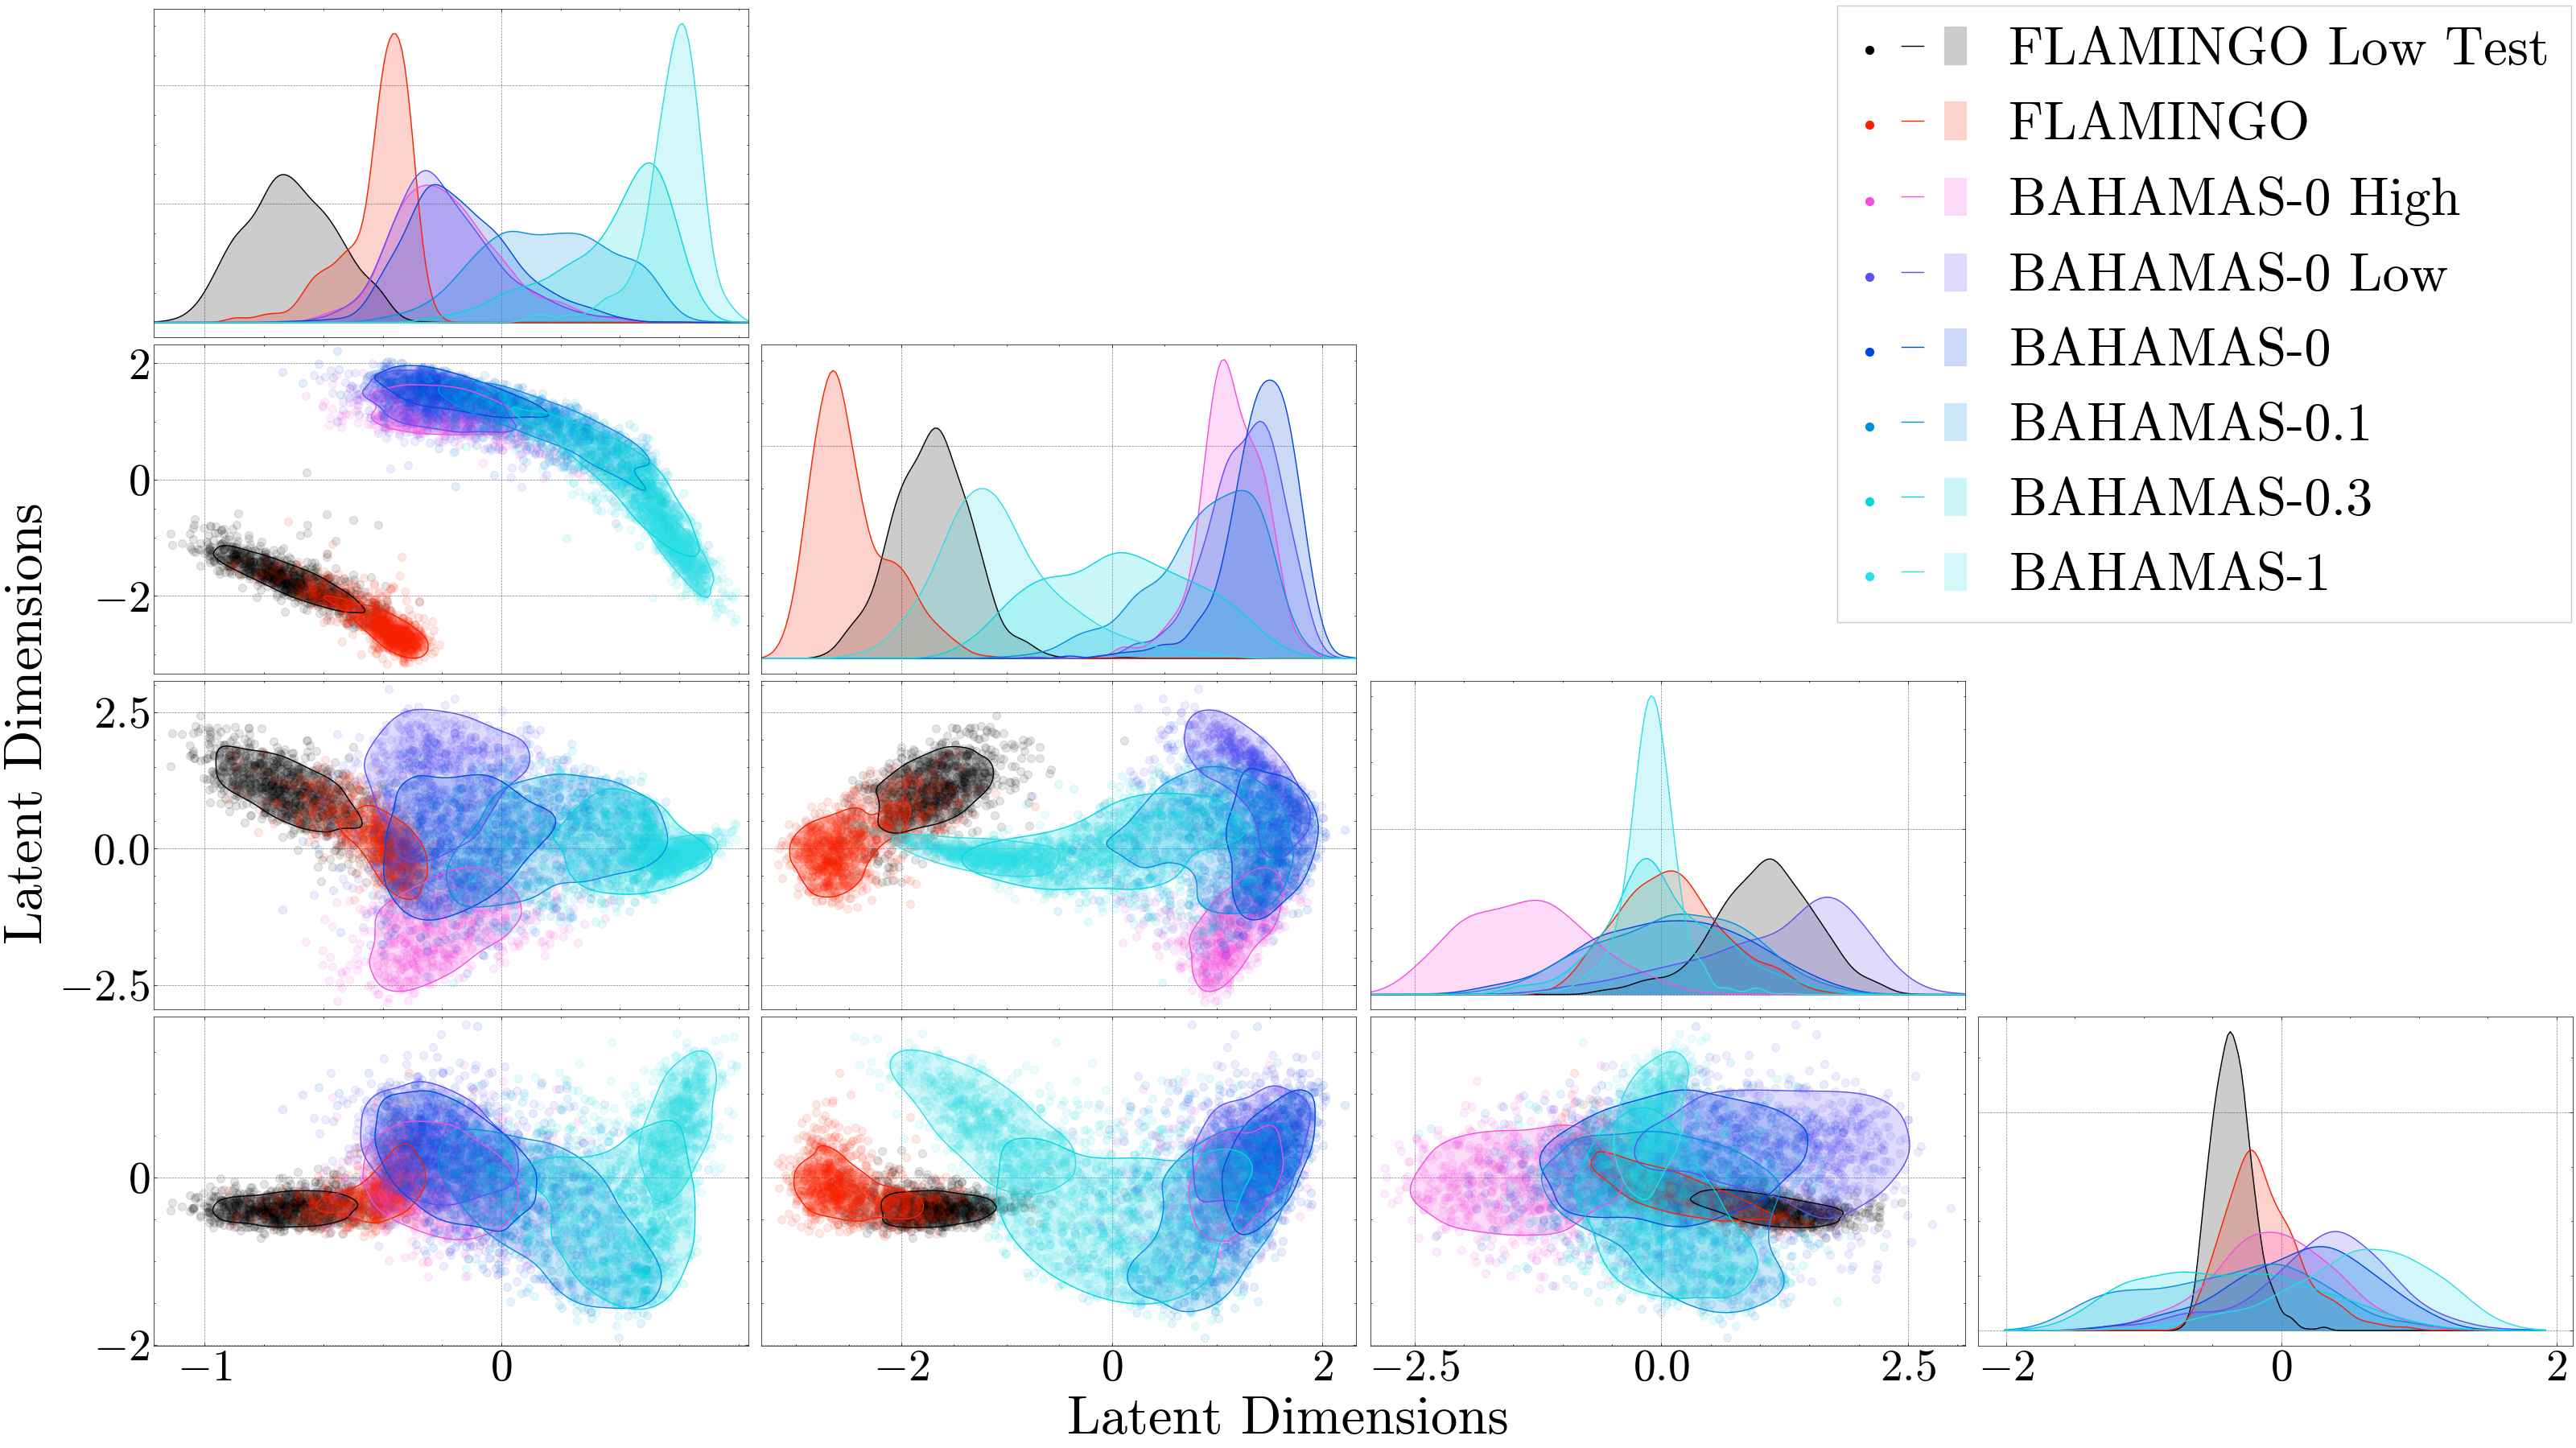

In [27]:
plot = plots.PlotClusters(
    # data['latent'],
    pca_transform,
    data['targets'],
    density=True,
    labels=labels,
    alpha=0.1,
    alpha_2d=0.2,
    colours=['k'] + flamingo_colours[2:] + bahamas_agn_colours + bahamas_colours,
    x_label='Latent Dimensions',
    y_label='Latent Dimensions',
    rows=len(labels),
    loc='upper right',
)